In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.special import factorial

sns.set_style("whitegrid")
pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = "{:.3f}".format # Only display up to three decimal places

### Initial computations

In [52]:
elections = pd.read_csv('data/Elections/all_elections.csv', parse_dates = ['Date Filed', 'Date Closed'])
elections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31904 entries, 0 to 31903
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Region                        31904 non-null  object        
 1   Case Number                   31904 non-null  object        
 2   Case Name                     31904 non-null  object        
 3   Status                        31904 non-null  object        
 4   Date Filed                    31904 non-null  datetime64[ns]
 5   Date Closed                   31484 non-null  datetime64[ns]
 6   Reason Closed                 31482 non-null  object        
 7   City                          31903 non-null  object        
 8   States & Territories          31904 non-null  object        
 9   Unit ID                       31904 non-null  object        
 10  Ballot Type                   31904 non-null  object        
 11  Tally Type                  

In [53]:
elections['Ballot Type'].value_counts()

Ballot Type
Single Labor Organization    29284
Two Labor Organizations       1573
Revised Single Labor Org       580
UD                             315
Three Labor Organizations      118
Revised Two Labor Orgs          34
Name: count, dtype: int64

In [54]:
# Restrict our attention to elections where only one union was on the ballot
single_elections = elections[elections['Ballot Type'] == 'Single Labor Organization']

In [55]:
# Restrict to representation elections
single_elections = single_elections[single_elections['Petition Type'] == 'RC']

In [56]:
# Set date closed as the index
single_elections.index = single_elections['Date Closed']

In [63]:
# Compute the percent yes vote in each election.
# Note that we could divide by the column 'Total Ballots Counted' but there are some cases where
# this seems to be erroneously equal to zero, e.g. 01-RC-270539. 
single_elections['Percent Votes Yes'] =  single_elections['Votes for Labor Union1'] / (single_elections[['Votes for Labor Union1', 'Votes Against', 'Challenged Ballots']].sum(axis = 1)) 
# Only display three decimal places
single_elections['Percent Votes Yes'] = single_elections['Percent Votes Yes'].round(3)

In [64]:
# Make it easier to read the win/loss outcome of the election
def get_outcome(row):
    if row['Percent Votes Yes'] > 0.5 or row['Reason Closed'] == "Certific. of Representative":
        return "Win"
    else:
        return "Loss"
single_elections['Outcome'] = single_elections.apply(get_outcome, axis = 1)

In [65]:
# Make a column that counts the number of new union members in successful union votes 
single_elections['Number Unionized'] = single_elections['No of Eligible Voters']*single_elections['Outcome'].apply(lambda x: 1 if x == "Win" else 0)

In [66]:
# Compute the duration of each case
single_elections['Duration'] = (single_elections['Date Closed']-single_elections['Date Filed']).apply(lambda x: x.days)

### General analysis

In [13]:
# Drop duplicate case numbers (some of these are re-runs of the same election)
single_elections = single_elections.drop_duplicates(subset=['Case Number'], keep = 'last')

In [69]:
# Resample to count the number of new union members per month
number_unionized_by_month = single_elections['Number Unionized'].resample("ME").sum()
number_unionized_by_day = single_elections['Number Unionized'].resample("D").sum()

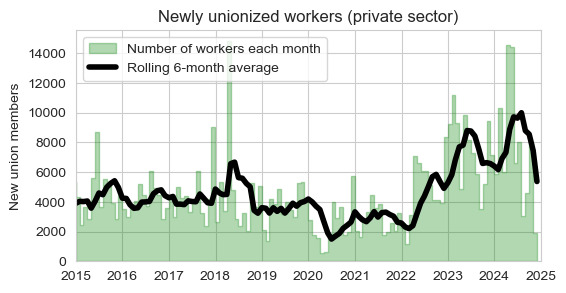

In [88]:
rolling_window_day = 182
rolling_window_month = 6
rolling_average_number_by_day = number_unionized_by_day.loc["2014-07":].rolling(rolling_window_day).mean()
rolling_average_number_by_month = number_unionized_by_month.loc["2014-07":].rolling(rolling_window_month).mean()
plt.figure(figsize = (6, 3))
plt.fill_between(number_unionized_by_month.loc["2014-12-31":].index, number_unionized_by_month.loc["2014-12-31":],  
                 color = 'green',
                 alpha = 0.3,
                 step='pre',
                label = f"Number of workers each month")
plt.plot(rolling_average_number_by_month.index, rolling_average_number_by_month, 
                 color = 'black',
                 linewidth = 4,
                label = f"Rolling 6-month average")
number_unionized_by_month.loc["2015":]
#plt.xlabel("Year")
plt.ylabel("New union members")
plt.ylim(bottom = 0)
plt.xlim(left = pd.to_datetime("2015-01-01"),right = pd.to_datetime("2025-1"))
plt.title(f"Newly unionized workers (private sector)")
plt.legend(loc = "upper left")
plt.savefig("new_union_members.png")
plt.show()

In [73]:
# Compute and display the five largest elections each year
# IMPORTANT: This data should include the ALU win in Staten Island (29-RC-288020)
# but it doesn't because this case is still listed as "open" in the NLRB database,
# due to Amazon contesting it.
five_biggest_by_year = single_elections.drop_duplicates(subset = 'Case Number').sort_values(by = "No of Eligible Voters",ascending = False)
five_biggest_by_year = five_biggest_by_year.groupby(by = five_biggest_by_year['Date Closed'].dt.year).head(5)
five_biggest_by_year['Year'] = five_biggest_by_year['Date Closed'].dt.year
five_biggest_by_year = five_biggest_by_year.sort_values(by = ['Year','No of Eligible Voters'], ascending = False)
filt = five_biggest_by_year['Year'] >= 2010
five_biggest_by_year = five_biggest_by_year[filt][['Year', 'Case Number', 'City', 'States & Territories', 'Union', 'No of Eligible Voters', 'Turnout', 'Percent Votes Yes', 'Outcome', 'Case Name']]
five_biggest_by_year['City']  = (five_biggest_by_year['City'] + ", " + five_biggest_by_year['States & Territories'])
five_biggest_by_year.drop(columns = ['States & Territories'], inplace = True)
five_biggest_by_year["No of Eligible Voters"] = five_biggest_by_year["No of Eligible Voters"].astype(int)
five_biggest_by_year = five_biggest_by_year.reset_index()
# Set styling to highlight alternating years and left-align the text and column headers
five_biggest_by_year = five_biggest_by_year.style.apply(lambda x: len(five_biggest_by_year.columns)*['background-color:#DDDDDD' if x['Year']%2 == 0 else 'background-color:white'], axis = 1)
five_biggest_by_year = five_biggest_by_year.hide(["Date Closed"], axis = 1).hide(axis = 'index')
five_biggest_by_year = five_biggest_by_year.set_properties(**{'text-align': 'left'})
five_biggest_by_year = five_biggest_by_year.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
five_biggest_by_year.format(precision=3)

Year,Case Number,City,Union,No of Eligible Voters,Turnout,Percent Votes Yes,Outcome,Case Name
2024,10-RC-338023,"Chattanooga, TN",UAW,4326,0.835,0.726,Win,"Volkswagen Group Of America, Inc."
2024,01-RC-336990,"Cambridge, MA",UAW,4172,0.282,0.871,Win,President And Fellows Of Harvard College
2024,04-RC-327396,"Philadelphia, PA",UAW,4003,0.476,0.779,Win,Trustees Of The University Of Pennsylvania
2024,29-RC-345119,"Brooklyn, NY",SEIU,2555,0.469,0.702,Win,"White Glove Community Care, Inc."
2024,21-RC-343623,"San Diego, CA",SEIU,1982,0.703,0.694,Win,Sharp Metropolitan
2023,32-RC-316964,"Stanford, CA",UE,3410,0.512,0.938,Win,The Board Of Trustees Of The Leland Stanford Junior University
2023,01-RC-305762,"New Haven, CT",UNITE HERE,3214,0.634,0.851,Win,Yale University
2023,13-RC-307974,"Chicago, IL",UE,3200,0.608,0.872,Win,University Of Chicago
2023,05-RC-309139,"Baltimore, MD",UE,3186,0.665,0.968,Win,Johns Hopkins University
2023,03-RC-326874,"Ithaca, NY",UE,3175,0.655,0.900,Win,Cornell University


In [74]:
filt = (single_elections['Duration'] >= 0) & (single_elections['Date Filed'] >= "2010")
durations = single_elections[filt]['Duration']
durations.index = single_elections[filt]['Date Filed']

In [75]:
# About 95% of cases are less than 200 days duration, so restrict our attention to those
print( (durations <= 200).sum()/(durations >= 0).sum() )
durations = durations[durations <= 200]

0.9371240839019459


In [76]:
# On average, a case lasts 55 days
durations.mean()

55.53087751469716

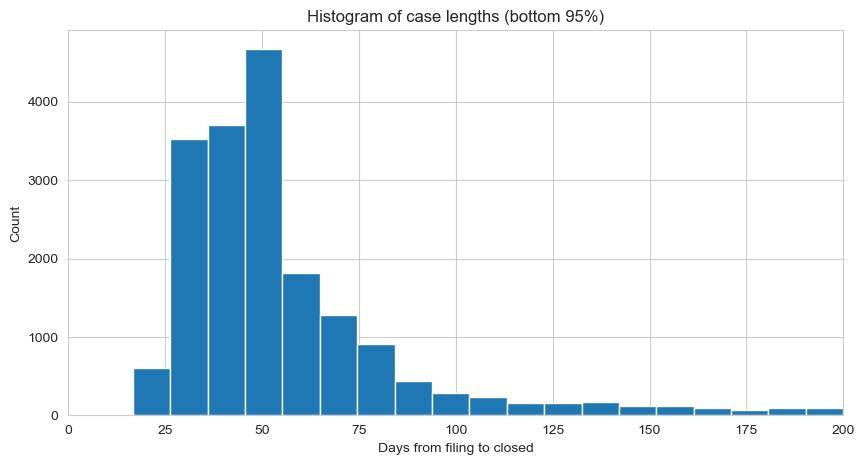

In [77]:
plt.figure(figsize = (10,5))
plt.hist(durations, bins = 20)
plt.xlim(left = 0, right = 200)
plt.ylabel("Count")
plt.xlabel("Days from filing to closed")
plt.title("Histogram of case lengths (bottom 95%)")
plt.show()


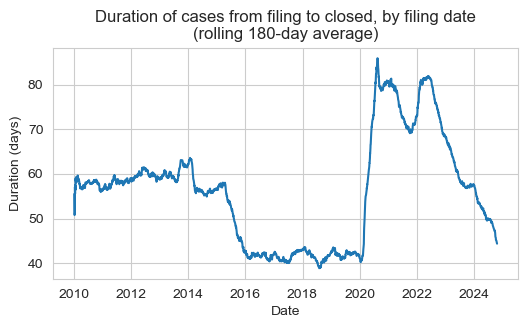

In [78]:
# Get rolling average of case durations
avg_duration_rolling = durations.sort_index().rolling("180D").agg(pd.Series.mean, skipna = True)
avg_duration_rolling = avg_duration_rolling[~avg_duration_rolling.index.duplicated(keep='last')]

plt.figure(figsize = (6,3))
plt.plot(avg_duration_rolling.index, avg_duration_rolling)
plt.xlabel("Date")
plt.ylabel("Duration (days)")
plt.title("Duration of cases from filing to closed, by filing date\n(rolling 180-day average)")
plt.show()

In [79]:
# Top ten unions
single_elections['Union'].value_counts().sort_values(ascending = False).head(11)

Union
TEAMSTERS         5251
SEIU              2872
UFCW              1778
OTHER             1744
IBEW              1543
IUOE              1535
IAM               1517
USW                741
AFSCME             611
CWA                566
SECURITY UNION     499
Name: count, dtype: int64

In [80]:
# Let's look at the elections for the top three
#unions_of_interest = ['TEAMSTERS', 'SEIU', 'UFCW', 'IAM', 'IBEW', 'IUOE', 'USW', 'AFSCME', 'CWA']
unions_of_interest = ['TEAMSTERS', 'SEIU', 'UFCW']
top_union_elections = single_elections[single_elections['Union'].apply(lambda x: x in unions_of_interest)]
top_union_elections = top_union_elections[['Turnout', 'Percent Votes Yes', 'Union', 'No of Eligible Voters']]
# Get rid of bad data outliers
top_union_elections = top_union_elections[top_union_elections['Turnout'] <= 1]
top_union_elections = top_union_elections[top_union_elections['Percent Votes Yes'] <= 1]
# Only look at elections with at least 20 workers
top_union_elections = top_union_elections[top_union_elections['No of Eligible Voters'] >= 20]

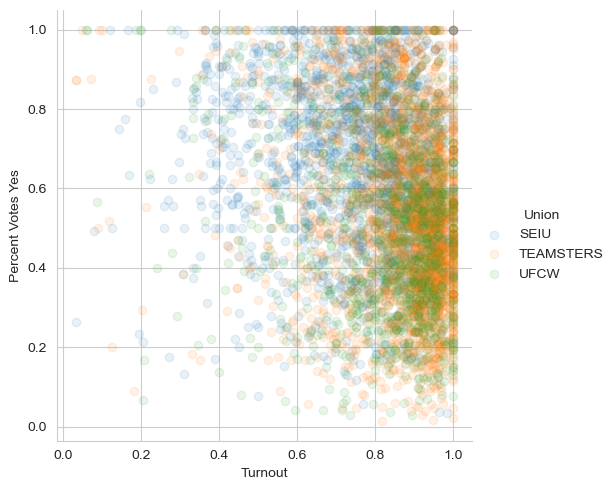

In [81]:
sns.lmplot(x = 'Turnout', y='Percent Votes Yes', data = top_union_elections,
            hue = 'Union', fit_reg = False,
          scatter_kws = {'alpha': 0.1})
plt.show()

In [82]:
# Let's look at the turnout and winrate for top unions
unions_of_interest = ['TEAMSTERS', 'SEIU', 'UFCW', 'IAM', 'IBEW', 'IUOE', 'USW', 'AFSCME', 'CWA']
top_union_elections = single_elections[single_elections['Union'].apply(lambda x: x in unions_of_interest)]
top_union_elections = top_union_elections[['Turnout', 'Percent Votes Yes', 'Union', 'No of Eligible Voters']]
# Get rid of bad data outliers
top_union_elections = top_union_elections[top_union_elections['Turnout'] <= 1]
top_union_elections = top_union_elections[top_union_elections['Percent Votes Yes'] <= 1]
# Only look at elections with at least 20 workers
top_union_elections = top_union_elections[top_union_elections['No of Eligible Voters'] >= 20]
top_union_elections.groupby(by='Union')[['Turnout', 'Percent Votes Yes']].mean().sort_values(by='Percent Votes Yes', ascending = False)

,Turnout,Percent Votes Yes
Union,,
SEIU,0.753,0.664
CWA,0.828,0.630
AFSCME,0.784,0.609
IAM,0.861,0.572
IUOE,0.863,0.564
TEAMSTERS,0.865,0.536
IBEW,0.845,0.517
USW,0.883,0.508
UFCW,0.820,0.502


In [132]:
closed_single_elections = single_elections[single_elections['Date Closed'].notna()].copy()
closed_single_elections.loc[:,'Year'] = closed_single_elections['Date Closed'].dt.year

In [207]:
votes_by_year = closed_single_elections.groupby(by = 'Year')[['Votes for Labor Union1', 'Votes Against', 'Challenged Ballots']].sum()
votes_by_year = votes_by_year.rename(columns = {'Votes for Labor Union1': "'Yes' votes", 'Votes Against':"'No' votes", 'Challenged Ballots':'Challenged ballots'})

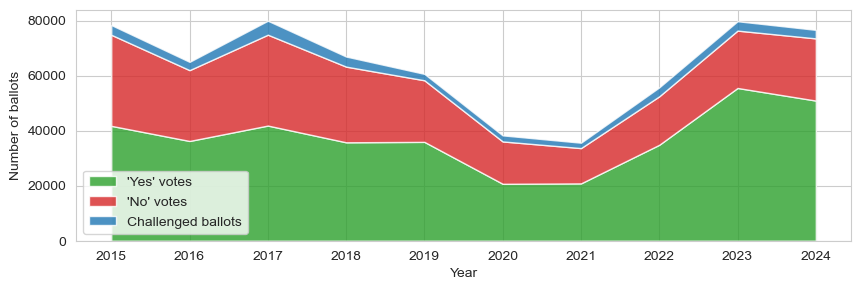

In [210]:
votes_by_year = votes_by_year.loc['2015':]
fig,ax = plt.subplots(figsize = (10,3))
plt.stackplot(votes_by_year.index,
              votes_by_year.transpose().values,
              labels = votes_by_year.columns,
              alpha = 0.8,
              colors = ['tab:green', 'tab:red', 'tab:blue']
             )
plt.legend()
ax.set_ylabel("Number of ballots")
ax.set_xlabel("Year")
ax.set_xticks(range(2015, 2025))
ax.set_xticklabels(range(2015, 2025))
plt.show()

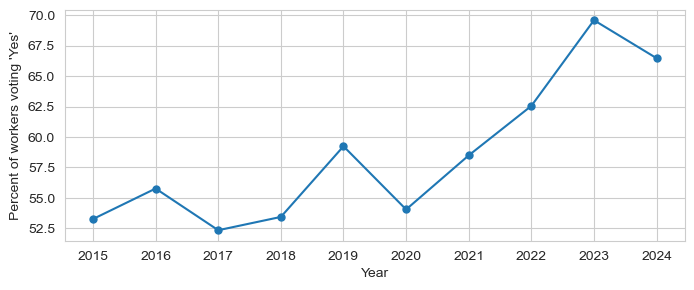

In [128]:
percent_yes_by_year = 100*votes_by_year['For']/votes_by_year.sum(axis = 1)

fig,ax = plt.subplots(figsize = (8,3))
plt.plot(percent_yes_by_year, ".-", markersize=10)
ax.set_ylabel("Percent of workers voting 'Yes'")
ax.set_xlabel("Year")
ax.set_xticks(range(2015, 2025))
ax.set_xticklabels(range(2015, 2025))
plt.show()

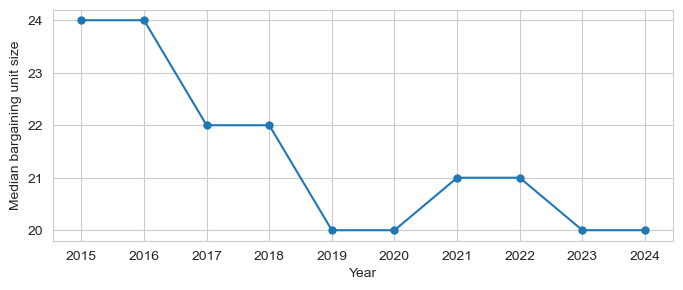

In [138]:
median_unit_size = closed_single_elections[closed_single_elections['Year'] > 2014].groupby(by = 'Year')['No of Eligible Voters'].median()

fig,ax = plt.subplots(figsize = (8,3))
plt.plot(median_unit_size, ".-", markersize=10)
ax.set_ylabel("Median bargaining unit size")
ax.set_xlabel("Year")
ax.set_xticks(range(2015, 2025))
ax.set_xticklabels(range(2015, 2025))
plt.show()

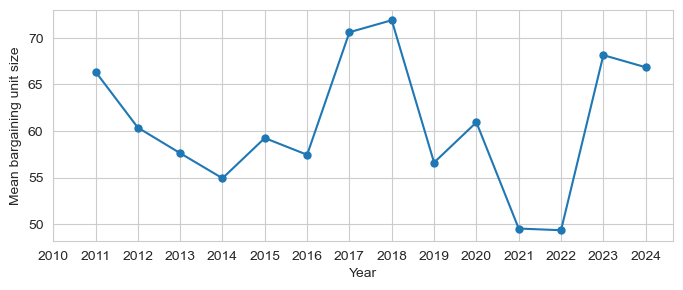

In [142]:
mean_unit_size = closed_single_elections[closed_single_elections['Year'] > 2010].groupby(by = 'Year')['No of Eligible Voters'].mean()

fig,ax = plt.subplots(figsize = (8,3))
plt.plot(mean_unit_size, ".-", markersize=10)
ax.set_ylabel("Mean bargaining unit size")
ax.set_xlabel("Year")
ax.set_xticks(range(2010, 2025))
ax.set_xticklabels(range(2010, 2025))
plt.show()

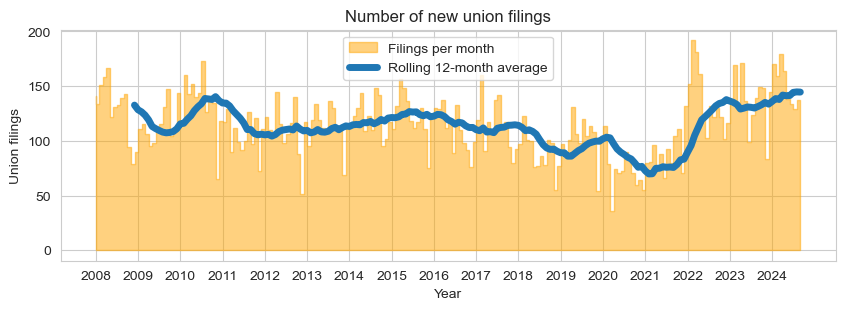

In [221]:
year = 2008
roll_window = 12
filt = (single_elections['Date Filed'] >= str(year)) & (single_elections['Date Filed'] < '2024-10')
filings_per_month = single_elections[filt]['Date Filed'].apply(lambda x: (x.year, x.month)).value_counts().sort_index()
roll = filings_per_month.rolling(roll_window).mean()

fig,ax = plt.subplots(figsize = (10,3))
plt.fill_between(range(len(filings_per_month)), filings_per_month.values, color = 'orange', label = 'Filings per month', zorder = 1, step='pre', alpha=0.5)
plt.plot(range(len(roll)), roll.values, color = 'tab:blue', alpha = 1.0, linewidth = 5, label = f'Rolling {roll_window}-month average', zorder = 2)
tix = range(0, len(filings_per_month), 12)
ax.set_xticks(tix)
ax.set_xticklabels([year+i//12 for i in tix])
ax.set_xlabel("Year")
ax.set_ylabel("Union filings")
plt.title("Number of new union filings")
plt.legend()
plt.show()

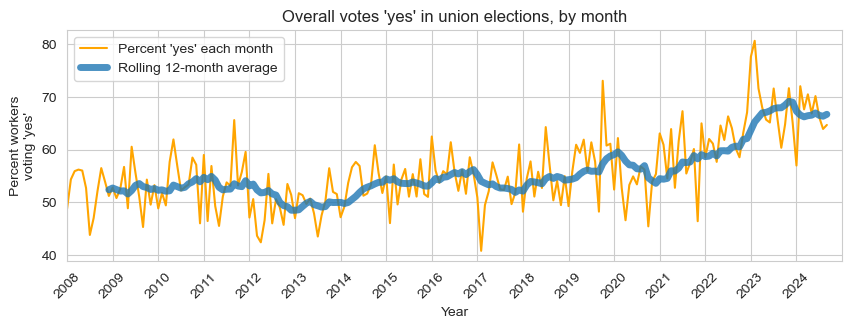

In [234]:
year = 2008
roll_window = 12
filt = (closed_single_elections['Date Closed'] >= str(year)) & (closed_single_elections['Date Closed'] < '2024-10')
ballots_by_month = closed_single_elections[filt].copy()
year_month = ballots_by_month['Date Closed'].apply(lambda x: (x.year, x.month))
ballots_by_month['Year, Month'] = year_month
ballots_by_month = ballots_by_month.groupby(by = 'Year, Month')[['Votes for Labor Union1', 'Votes Against', 'Challenged Ballots']].sum()
vote_rate_by_month = ballots_by_month['Votes for Labor Union1']/ballots_by_month.sum(axis = 1)
roll = vote_rate_by_month.rolling(roll_window).mean()

fig,ax = plt.subplots(figsize = (10,3))
plt.plot(range(len(vote_rate_by_month)), 100*vote_rate_by_month.values, color = 'orange', label = "Percent 'yes' each month", zorder = 1)
plt.plot(range(len(roll)), 100*roll.values, color = 'tab:blue', alpha = 0.8, linewidth = 5, label = f'Rolling {roll_window}-month average', zorder = 2)
tix = range(0, len(vote_rate_by_month), 12)
ax.set_xticks(tix)
ax.set_xticklabels([year+i//12 for i in tix], rotation = 45)
ax.set_xlabel("Year")
ax.set_ylabel("Percent workers\nvoting 'yes'")
plt.xlim(left = tix[0])
plt.xlim(right = tix[-1]+12)
plt.title("Overall votes 'yes' in union elections, by month")
plt.legend()
plt.show()

In [235]:
# Looking at elections round beginning of 2023, when big spike in number voting yes
# Seems the spike is almost purely driven by academic votes: JHU, USC, UChicago, Boston U, Northwestern, and Yale.
filt = (single_elections['Date Closed'] >= '12-2022') & (single_elections['Date Closed'] <= '04-2023')
early_2023 = single_elections[filt]

In [239]:
early_2023.sort_values(by = 'Number Unionized', ascending = False)

,Region,Case Number,Case Name,Status,Date Filed,Date Closed,Reason Closed,City,States & Territories,Unit ID,...,Voting Unit (Unit B),Voting Unit (Unit C),Voting Unit (Unit D),Petition Type,Union,Turnout,Percent Votes Yes,Outcome,Number Unionized,Duration
Date Closed,,,,,,,,,,,,,,,,,,,,,
2023-01-18,"Region 01, Boston, Massachusetts",01-RC-305762,Yale University,Closed,2022-10-24,2023-01-18,Certific. of Representative,New Haven,CT,A,...,NaN,NaN,NaN,RC,UNITE HERE,0.634,0.851,Win,3214.000,86.000
2022-12-16,"Region 01, Boston, Massachusetts",01-RC-305360,Trustees Of Boston University,Closed,2022-10-18,2022-12-16,Certific. of Representative,Boston,MA,A,...,NaN,NaN,NaN,RC,SEIU,0.450,0.806,Win,3206.000,59.000
2023-03-24,"Region 13, Chicago, Illinois",13-RC-307974,University Of Chicago,Closed,2022-11-30,2023-03-24,Certific. of Representative,Chicago,IL,A,...,NaN,NaN,NaN,RC,UE,0.608,0.872,Win,3200.000,114.000
2023-02-08,"Region 05, Baltimore, Maryland",05-RC-309139,Johns Hopkins University,Closed,2022-12-19,2023-02-08,Certific. of Representative,Baltimore,MD,A,...,NaN,NaN,NaN,RC,UE,0.665,0.968,Win,3186.000,51.000
2023-01-23,"Region 13, Chicago, Illinois",13-RC-307313,Northwestern University,Closed,2022-11-17,2023-01-23,Certific. of Representative,Evanston,IL,A,...,NaN,NaN,NaN,RC,UE,0.671,0.816,Win,3000.000,67.000
2023-02-27,"Region 31, Los Angeles, California",31-RC-308858,University Of Southern California,Closed,2022-12-14,2023-02-27,Certific. of Representative,Los Angeles,CA,A,...,NaN,NaN,NaN,RC,UAW,0.602,0.847,Win,2861.000,75.000
2023-02-06,"Region 03, Buffalo, New York",03-RC-309080,University Of Vermont Medical Center,Closed,2022-12-19,2023-02-06,Certific. of Representative,Burlington,VT,A,...,NaN,NaN,NaN,RC,TEACHER UNION,0.581,0.814,Win,1996.000,49.000
2023-03-07,"Region 02, New York, New York",02-RC-308481,Montefiore Medical Center,Closed,2022-12-08,2023-03-07,Certific. of Representative,The Bronx,NY,A,...,NaN,NaN,NaN,RC,SEIU,0.637,0.764,Win,1188.000,89.000
2022-12-23,"Region 08, Cleveland, Ohio",08-RC-306216,Ultium Cells Llc,Closed,2022-10-31,2022-12-23,Certific. of Representative,Warren,OH,A,...,NaN,NaN,NaN,RC,UAW,0.932,0.978,Win,779.000,53.000


### Starbucks

In [27]:
starbucks_elections = elections[elections['Case Name'].astype(str).apply(lambda x: "starbuck" in x.lower()) | elections['Labor Union1'].astype(str).apply(lambda x: "starbuck" in x.lower())]

In [28]:
starbucks_elections.info()

<class 'pandas.core.frame.DataFrame'>
Index: 670 entries, 23643 to 29710
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Region                        670 non-null    object        
 1   Case Number                   670 non-null    object        
 2   Case Name                     670 non-null    object        
 3   Status                        670 non-null    object        
 4   Date Filed                    670 non-null    datetime64[ns]
 5   Date Closed                   648 non-null    datetime64[ns]
 6   Reason Closed                 648 non-null    object        
 7   City                          669 non-null    object        
 8   States & Territories          670 non-null    object        
 9   Unit ID                       670 non-null    object        
 10  Ballot Type                   670 non-null    object        
 11  Tally Type                    6

In [29]:
starbucks_elections['Date Closed'].dt.year.value_counts()

Date Closed
2022.000    340
2024.000    170
2023.000    137
2021.000      1
Name: count, dtype: int64

In [30]:
starbucks_elections['Petition Type'].value_counts()

Petition Type
RC    664
RM      6
Name: count, dtype: int64

In [31]:
starbucks_elections['Reason Closed'].value_counts()

Reason Closed
Certific. of Representative    536
Certification of Results       108
Withdrawal Non-adjusted          2
Dismissal Non-adjusted           1
Withdrawal Adjusted              1
Name: count, dtype: int64

In [32]:
starbucks_elections = starbucks_elections[['Petition Type', 'No of Eligible Voters', 'Void Ballots', 'Votes for Labor Union1', 'Votes Against', 'Total Ballots Counted', 'Turnout', 'Challenged Ballots', 'Challenges are Determinative', 'Union','Case Number', 'Case Name', 'Status', 'Reason Closed', 'Date Filed', 'Date Closed', 'City', 'States & Territories', 'Region']]

In [33]:
starbucks_elections.index = starbucks_elections['Date Closed']

In [35]:
# Number of filings per month
filings_per_month = starbucks_elections[starbucks_elections['Petition Type'] == 'RC']['Petition Type'].apply(lambda x: 1 ).resample("ME").sum()

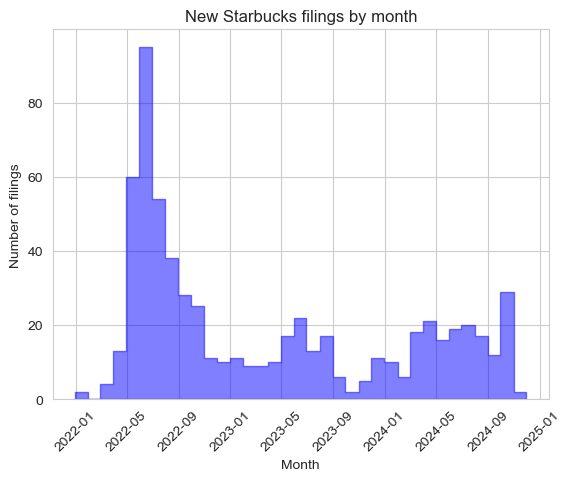

In [36]:
plt.fill_between(filings_per_month.index,filings_per_month, color = 'blue', alpha=0.5, step='pre')
plt.ylabel("Number of filings")
plt.xticks(rotation = 45)
plt.xlabel("Month")
plt.ylim(bottom = 0)
plt.title("New Starbucks filings by month")
plt.show()

### UE

In [37]:
ue_elections = single_elections[single_elections['Union'] == "UE"]

In [38]:
ue_elections.index = ue_elections['Date Closed']

In [39]:
ue_elections.groupby(by = ue_elections['Date Closed'].dt.year)['Outcome'].value_counts()

Date Closed  Outcome
2007         Loss       1
             Win        1
2008         Win        7
             Loss       3
2010         Win        3
             Loss       1
2011         Win        1
2012         Loss       2
             Win        2
2013         Win        1
2014         Loss       1
             Win        1
2015         Win        5
2016         Win        5
2017         Win        4
             Loss       2
2018         Win        1
2019         Win        2
2020         Win        1
2021         Win        2
             Loss       1
2022         Win        2
2023         Win        6
2024         Loss       1
             Win        1
Name: count, dtype: int64

In [40]:
ue_elections['Number Unionized'] = ue_elections['No of Eligible Voters']*ue_elections['Outcome'].apply(lambda x: 1 if x == "Win" else 0)

/var/folders/pz/n_v30dyj09bfnyhk_h1dnfnm0000gn/T/ipykernel_11292/3444951292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ue_elections['Number Unionized'] = ue_elections['No of Eligible Voters']*ue_elections['Outcome'].apply(lambda x: 1 if x == "Win" else 0)


In [41]:
number_unionized_by_month = ue_elections['Number Unionized'].resample("ME").sum()

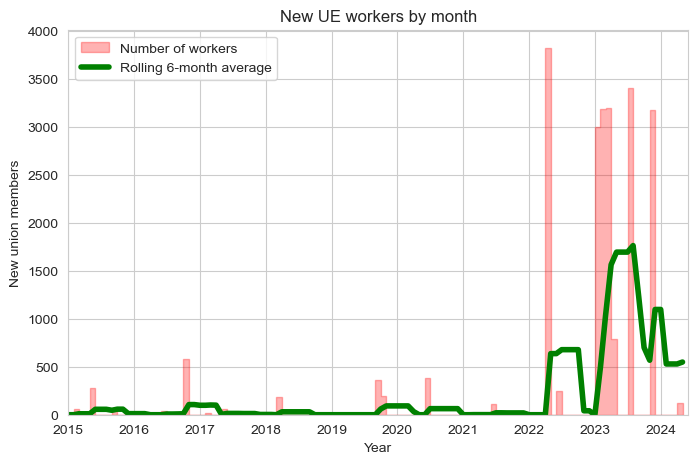

In [42]:
rolling_window = 6
rolling_average_number_by_month = number_unionized_by_month.loc["2014-07":"2024-04"].rolling(rolling_window).mean()
plt.figure(figsize = (8, 5))
plt.fill_between(number_unionized_by_month.loc["2014-12-31":"2024-04"].index, number_unionized_by_month.loc["2014-12-31":"2024-04"],  
                 color = 'red',
                 alpha = 0.3,
                 step='pre',
                label = f"Number of workers")
plt.plot(rolling_average_number_by_month.index, rolling_average_number_by_month, 
                 color = 'green',
                 linewidth = 4,
                label = f"Rolling {rolling_window}-month average")
number_unionized_by_month.loc["2015":"2024-04"]
plt.xlabel("Year")
plt.ylabel("New union members")
plt.ylim(bottom = 0)
plt.xlim(left = pd.to_datetime("2015-01-01"),right = pd.to_datetime("2024-06"))
plt.title(f"New UE workers by month")
plt.legend(loc = 'upper left')
plt.show()

In [44]:
ue_view = ue_elections[['Region', 'Case Number', 'Case Name', 'Status', 'Date Filed','Percent Votes Yes', 'Outcome', 'No of Eligible Voters',
       'Date Closed', 'Reason Closed', 'City', 'States & Territories','Turnout',
       'Number Unionized', 'Duration']].sort_index()
ue_view.index = list(range(len(ue_view)))
ue_view.style.apply(lambda x: 15*['background-color:#AAFFAA' if x['Outcome'] == "Win" else 'background-color:white'], axis = 1)

,Region,Case Number,Case Name,Status,Date Filed,Percent Votes Yes,Outcome,No of Eligible Voters,Date Closed,Reason Closed,City,States & Territories,Turnout,Number Unionized,Duration
0,"Region 22, Newark, New Jersey",22-RC-012310,"Hishi Plastic, Inc.",Closed,2003-02-10 00:00:00,0.846000,Win,42.000000,2007-03-27 00:00:00,Certific. of Representative,Lincoln Park,NJ,0.904762,42.000000,1506.000000
1,"Region 01, Boston, Massachusetts",01-RC-022095,Committee On Temporary Shelter (Cots),Closed,2007-03-02 00:00:00,0.447000,Loss,39.000000,2007-04-12 00:00:00,Certification of Results,Burlington,VT,0.948718,0.000000,41.000000
2,"Region 01, Boston, Massachusetts",01-RC-022172,Choctaw Archiving Enterprises,Closed,2007-12-21 00:00:00,0.622000,Win,87.000000,2008-02-11 00:00:00,Certific. of Representative,Saint Albans,VT,0.942529,87.000000,52.000000
3,"Region 01, Boston, Massachusetts",01-RC-022173,"Northrop Grumman Technical Services, Inc.",Closed,2007-12-21 00:00:00,0.588000,Win,107.000000,2008-02-11 00:00:00,Certific. of Representative,Saint Albans,VT,0.906542,107.000000,52.000000
4,"Region 01, Boston, Massachusetts",01-RC-022174,Federal Working Group,Closed,2007-12-21 00:00:00,0.400000,Loss,20.000000,2008-02-11 00:00:00,Certification of Results,Saint Albans,VT,1.000000,0.000000,52.000000
5,"Region 21, Los Angeles, California",21-RC-021007,Studley Professional Staffing,Closed,2008-01-23 00:00:00,0.742000,Win,34.000000,2008-03-05 00:00:00,Certific. of Representative,Laguna Niguel,CA,0.911765,34.000000,42.000000
6,"Region 21, Los Angeles, California",21-RC-021006,Choctaw Archiving Enterprises,Closed,2008-01-23 00:00:00,0.919000,Win,151.000000,2008-03-06 00:00:00,Certific. of Representative,Laguna Niguel,CA,0.894040,151.000000,43.000000
7,"Region 21, Los Angeles, California",21-RC-021008,"Northrop Grumman Technical Services, Inc., A Subsidiary Of Northrop Grumman Systems Corp.",Closed,2008-01-24 00:00:00,0.724000,Win,154.000000,2008-03-06 00:00:00,Certific. of Representative,Laguna Niguel,CA,0.941558,154.000000,42.000000
8,"Region 21, Los Angeles, California",21-RC-021009,"Stanley Associates, Inc.",Closed,2008-01-24 00:00:00,0.575000,Win,185.000000,2008-03-14 00:00:00,Certific. of Representative,Laguna Niguel,CA,0.962162,185.000000,50.000000
9,"Region 01, Boston, Massachusetts",01-RC-022171,"Stanley Associates, Inc.",Closed,2007-12-21 00:00:00,0.373000,Loss,166.000000,2008-03-20 00:00:00,Certification of Results,Saint Albans,VT,0.843373,0.000000,90.000000
